In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torchvision import datasets

import os
import cv2
import numpy as np


In [2]:
cd training_pytorch

/home/shreeyash-legion/assignments/DD/training_pytorch


In [3]:
# #! Dataclass for problem

# class Load_Jaw_Data(Dataset):

#     def __init__(self,path):
        

    
#     def __getitem__(self):

#     def __len__(self):







In [4]:
image_transforms = {

    "train": transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor()
    ]),

    "val": transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor()
    ])


}

In [5]:
dataset_complete = datasets.ImageFolder('./with_jaw',transform=image_transforms["train"])

In [6]:
dataset_complete.class_to_idx

{'front': 0, 'left': 1, 'lower': 2, 'right': 3, 'upper': 4}

In [7]:
dataset_complete.samples

[('./with_jaw/front/01 front.jpg', 0),
 ('./with_jaw/front/02 front.jpg', 0),
 ('./with_jaw/front/03 front.jpg', 0),
 ('./with_jaw/left/01 left.jpg', 1),
 ('./with_jaw/left/02 left.jpg', 1),
 ('./with_jaw/left/03 left.jpg', 1),
 ('./with_jaw/lower/01 lower.jpg', 2),
 ('./with_jaw/lower/02 lower.jpg', 2),
 ('./with_jaw/lower/03 lower.jpg', 2),
 ('./with_jaw/right/01 right.jpg', 3),
 ('./with_jaw/right/02 right.jpg', 3),
 ('./with_jaw/right/03 right.jpg', 3),
 ('./with_jaw/upper/01 upper.jpg', 4),
 ('./with_jaw/upper/02 upper.jpg', 4),
 ('./with_jaw/upper/03 upper.jpg', 4)]

In [8]:
import seaborn as sns

id_2_class = {v:k for k,v in dataset_complete.class_to_idx.items()}
count_dict = {k:0 for k,v in dataset_complete.class_to_idx.items()}


for item in dataset_complete:
    y = item[1]
    y = id_2_class[y]
    count_dict[y] += 1

In [9]:
count_dict

{'front': 3, 'left': 3, 'lower': 3, 'right': 3, 'upper': 3}

In [10]:
import pandas as pd

<AxesSubplot:>

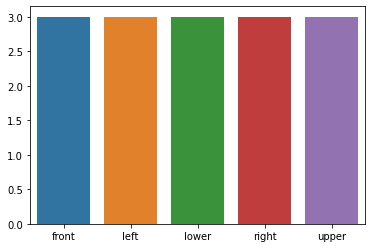

In [11]:
sns.barplot(data=pd.DataFrame.from_dict([count_dict]))

In [12]:
from torch.utils.data import random_split

In [13]:
train,val = random_split(dataset_complete,(10,5))

In [14]:
len(train)

10

In [15]:
len(val)

5

In [30]:
train_dl = DataLoader(dataset=train,shuffle=True,batch_size=4)
val_dl = DataLoader(dataset=val,shuffle=False,batch_size=5)


In [17]:
next(iter(train_dl))[1]

tensor([4, 0, 4, 0])

In [20]:
#from models.resnet import resnet18
#model = resnet18("LN").to(device)
from utils.helper import model_summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class BasicBlock(nn.Module):
    """
    Basic block of the ResNet.
    """

    expansion = 1

    def __init__(self, in_planes, planes, norm_type, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(1, planes) if norm_type == "LN" else nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(1, planes) if norm_type == "LN" else nn.BatchNorm2d(planes)

        # self.shortcut = nn.Sequential()
        # if stride != 1 or in_planes != self.expansion * planes:
        #     self.shortcut = nn.Sequential(
        #         nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
        #         nn.GroupNorm(1, self.expansion * planes)
        #         if norm_type == "LN"
        #         else nn.BatchNorm2d(self.expansion * planes),
        #     )

    def forward(self, x):
        """
        Forward method.
        """
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        #out += self.shortcut(x)
        out = F.relu(out)
        return out

class CustomResNetClass(nn.Module):
    """
    ResNet Architecture.
    """

    def __init__(self, block, norm_type, num_classes=10):
        super().__init__()
    #    self.in_planes = 64

    #     self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    #     self.bn1 = nn.GroupNorm(1, 64) if norm_type == "LN" else nn.BatchNorm2d(64)
    #     self.layer1 = self._make_layer(block, 64, num_blocks[0], norm_type, stride=1)
    #     self.layer2 = self._make_layer(block, 128, num_blocks[1], norm_type, stride=2)
    #     self.layer3 = self._make_layer(block, 256, num_blocks[2], norm_type, stride=2)
    #     self.layer4 = self._make_layer(block, 512, num_blocks[3], norm_type, stride=1)
    #     self.linear = nn.Linear(512 * block.expansion, num_classes)

    # def _make_layer(self, block, planes, num_blocks, norm_type, stride):
    #     strides = [stride] + [1] * (num_blocks - 1)
    #     layers = []
    #     for stride_ in strides:
    #         layers.append(block(self.in_planes, planes, norm_type, stride_))
    #         self.in_planes = planes * block.expansion
    #     return nn.Sequential(*layers)

        self.prep = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1,stride=1), # RF: 3x3
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1), # RF: 3x3
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.resblock_1 = block(128,128,norm_type="BN")
        
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
    
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.resblock_2 = block(512,512,norm_type="BN")
        self.pooling = nn.MaxPool2d(4,4)
        self.fc1 = nn.Linear(512*8*8,5)


    def forward(self, x):
        """
        Forward method.
        """
        out = self.prep(x)
        out = self.conv_layer_1(out)
        
        res_out_1=self.resblock_1(out)
        
        out = out + res_out_1

        out = self.conv_layer_2(out)

        out = self.conv_layer_3(out)

        res_out_2=self.resblock_2(out)
        
        out = out + res_out_2 
        
        out = self.pooling(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        
        #out = F.softmax(out,dim=1)
        return out

def CustomResNet(norm_type="BN"):
    return CustomResNetClass(BasicBlock,norm_type)

model = CustomResNet("BN").to(device)

model_summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
       BatchNorm2d-3         [-1, 64, 256, 256]             128
            Conv2d-4        [-1, 128, 256, 256]          73,856
         MaxPool2d-5        [-1, 128, 128, 128]               0
       BatchNorm2d-6        [-1, 128, 128, 128]             256
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,456
       BatchNorm2d-9        [-1, 128, 128, 128]             256
           Conv2d-10        [-1, 128, 128, 128]         147,456
      BatchNorm2d-11        [-1, 128, 128, 128]             256
       BasicBlock-12        [-1, 128, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         295,168
        MaxPool2d-14          [-1, 256,

In [21]:
import torch.optim as optim
epochs = 5
lr = 0.001
l1_factor = 0

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [22]:
from utils.test import test
from utils.train import train

from torch.optim.lr_scheduler import OneCycleLR
#l1_factor = 0

def trainer(model, epochs, device, train_loader, test_loader, optimizer, criterion, l1_factor, use_scheduler=True):
    """
    Train and evaluate for given epochs.
    """
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    lrs = []
    #if use_scheduler:
    
    #scheduler = OneCycleLR(optimizer, max_lr = max_lr[1],epochs = 24, steps_per_epoch= len(train_loader),div_factor=10,pct_start=0.2)
    scheduler = OneCycleLR(optimizer, max_lr = 0.1,epochs = 24, steps_per_epoch= len(train_loader),div_factor=10,pct_start=0.2)
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}:")
        train(model, device, train_loader, optimizer, train_accuracy, train_losses, l1_factor, criterion, lrs,scheduler=None)
        test(model, device, test_loader, test_accuracy, test_losses, criterion)

        #if use_scheduler:
        scheduler.step(test_accuracy[-1])

    return train_accuracy, train_losses, test_accuracy, test_losses

In [23]:
train_accuracy, train_losses, test_accuracy, test_losses = trainer(model, epochs, device, train_dl, val_dl, optimizer, criterion, l1_factor)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:


Train Loss=872.8766479492188 Batch_id=2 LR= 0.01000 Train Accuracy= 10.00: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]
  0%|          | 0/3 [00:00<?, ?it/s]


: Average Test loss: 21520.0648, Test Accuracy: 1/5 (20.00%)

Epoch 2:


Train Loss=148.00225830078125 Batch_id=2 LR= 0.09680 Train Accuracy= 10.00: 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]
  0%|          | 0/3 [00:00<?, ?it/s]


: Average Test loss: 1880314.4000, Test Accuracy: 1/5 (20.00%)

Epoch 3:


Train Loss=0.0 Batch_id=2 LR= 0.09680 Train Accuracy= 50.00: 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]
  0%|          | 0/3 [00:00<?, ?it/s]


: Average Test loss: 88831.1812, Test Accuracy: 1/5 (20.00%)

Epoch 4:


Train Loss=11.712272644042969 Batch_id=2 LR= 0.09680 Train Accuracy= 70.00: 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]
  0%|          | 0/3 [00:00<?, ?it/s]


: Average Test loss: 8766.5344, Test Accuracy: 1/5 (20.00%)

Epoch 5:


Train Loss=0.8079407811164856 Batch_id=2 LR= 0.09680 Train Accuracy= 90.00: 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]



: Average Test loss: 1636.0364, Test Accuracy: 1/5 (20.00%)



Total wrong predictions are 4


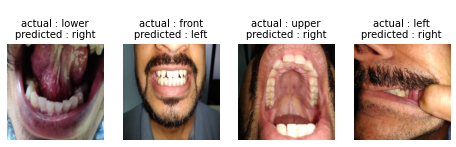

In [31]:
from utils.plot_utils import misclassified_images
labels = dataset_complete.classes
images_misclassified = misclassified_images(model, val_dl, device,labels)

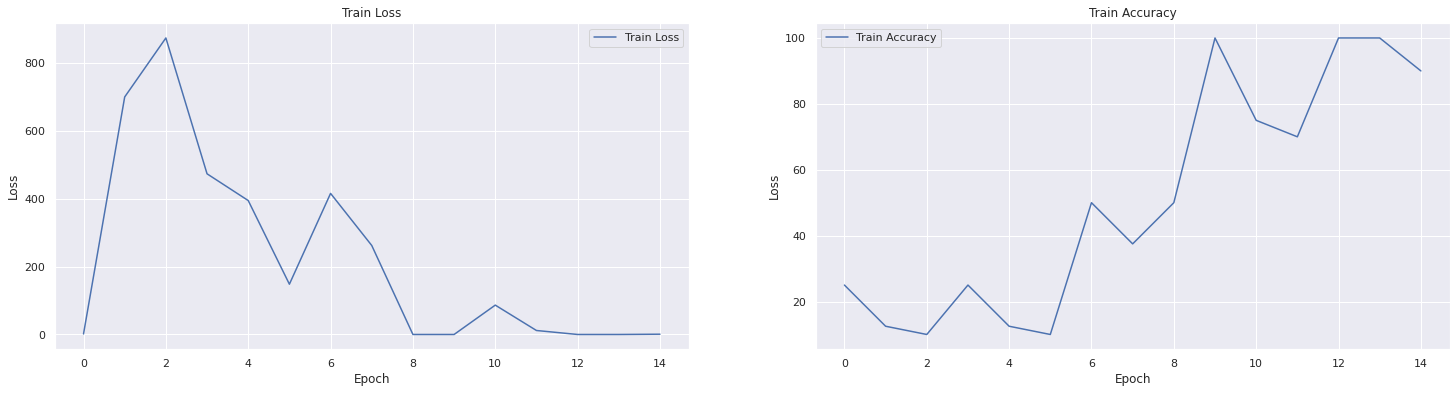

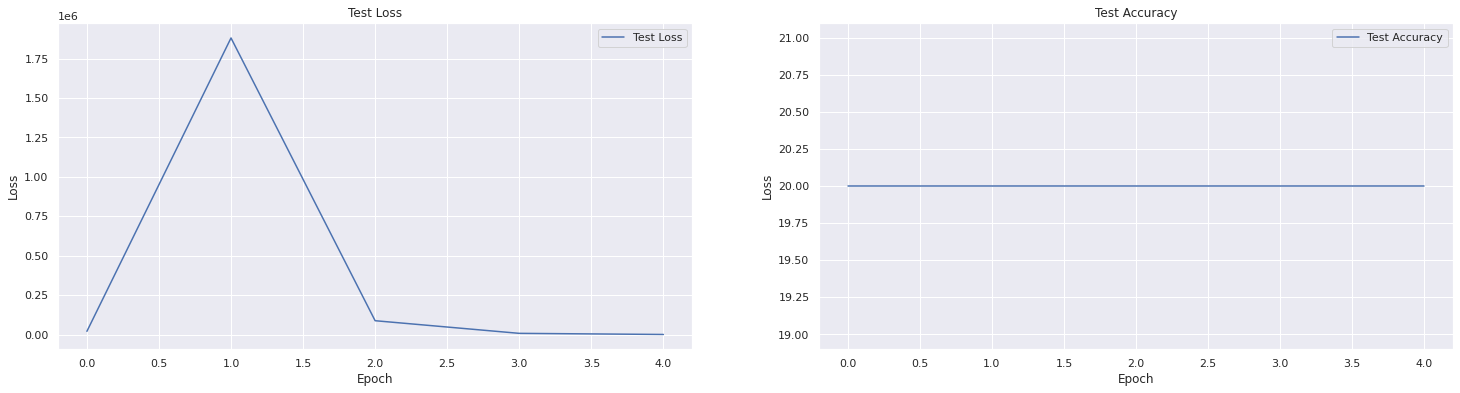

In [33]:
from utils.plot_utils import plot_metrics

plot_metrics((train_accuracy, train_losses, test_accuracy, test_losses))

In [35]:
from utils.helper import class_level_accuracy

class_level_accuracy(model, val_dl, device, labels)

Accuracy of front :  0 %
Accuracy of  left :  0 %
Accuracy of lower :  0 %
Accuracy of right : 100 %
Accuracy of upper :  0 %


Generating Grad-CAM for conv_layer_1
Generating Grad-CAM for conv_layer_2
Generating Grad-CAM for conv_layer_3


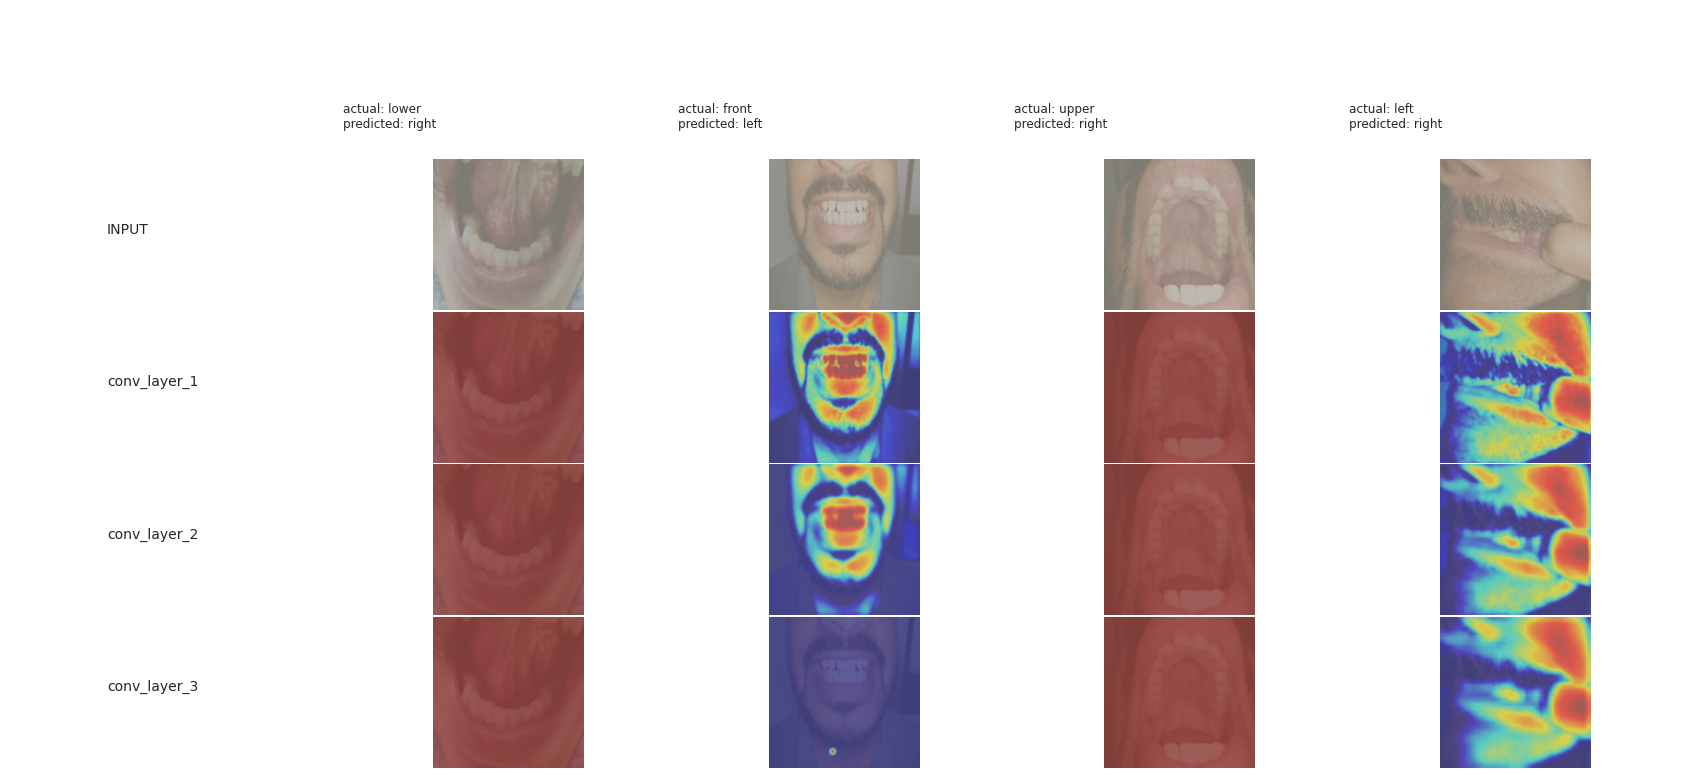

In [36]:
from utils.grad_cam import generate_gradcam, plot_gradcam

target_layers = ["conv_layer_1", "conv_layer_2", "conv_layer_3"]
gradcam_output, probs, predicted_classes = generate_gradcam(images_misclassified[:5], model, target_layers, device)
plot_gradcam(gradcam_output, target_layers, labels, (3, 256, 256), predicted_classes, images_misclassified[:10])